In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import json
from dataclasses import asdict

# Import the lorenz96 simulator
from simulator.simulator_Lorenz_96 import (
    simulate_lorenz96,
    Lorenz96SimulationResult,
    compute_rmse,
    compute_ensemble_spread,
    l96_integrate,
    ObsModel
)

print("✓ Imported simulator from simulator_Lorenz_96.py")

✓ Imported simulator from simulator_Lorenz_96.py


In [3]:
# Run the simulation
print("Running Lorenz 96 simulation...")

result = simulate_lorenz96(
    nx=1000,
    F=8.0,
    dt=0.01,
    spinup_steps=1000,
    total_steps=1500,
    Np=20,
    obs_interval=20,
    obs_fraction=4,
    obs_error_std=1.0,
    seed=42
)

# Store a copy for later use in sequential experiments
result_original = result

print("\nSimulation complete!")
print(f"Truth trajectory shape: {result.truth_traj.shape}")
print(f"Ensemble trajectory shape: {result.ensemble_traj.shape}")
print(f"Observations shape: {result.observations.shape}")
print(f"Number of observation times: {len(result.obs_times)}")

# Display configuration
print("\nConfiguration:")
for key, value in result.config.items():
    print(f"  {key}: {value}")

Running Lorenz 96 simulation...

Simulation complete!
Truth trajectory shape: (1501, 1000)
Ensemble trajectory shape: (20, 1501, 1000)
Observations shape: (76, 250)
Number of observation times: 76

Configuration:
  nx: 1000
  F: 8.0
  dt: 0.01
  spinup_steps: 1000
  total_steps: 1500
  Np: 20
  obs_interval: 20
  obs_fraction: 4
  obs_error_std: 1.0
  perturbation_std: 1.4142135623730951
  seed: 42
  ny: 250
  n_obs_times: 76


In [4]:
# Import kernel particle filter modules
from models.kernel_particle_filter import (
    KernelParticleFilter,
    Model,
    KPFConfig,
    KPFState
)

print("✓ Imported Kernel Particle Filter module")

✓ Imported Kernel Particle Filter module


In [5]:
# Extract data for the first assimilation update (at t=20, obs_idx=1)
obs_idx_first = 1  # First update after initial time
t_first = result.obs_times[obs_idx_first]
y_first = result.observations[obs_idx_first]

# Get prior ensemble (forecast to t=20)
X_prior = result.ensemble_traj[:, t_first, :].copy()  # (Np, nx)

# Select variables to analyze
var_unobserved = 19  # x[19] - unobserved component
var_observed = 20    # x[20] - observed component

# Variable labels for plotting
var_labels = [f'x[{var_unobserved}] (unobserved)', f'x[{var_observed}] (observed)']
vars_to_plot = [var_unobserved, var_observed]

# Get truth values
truth_first = result.truth_traj[t_first]

print(f"Analysis at t = {t_first} (time = {t_first * result.config['dt']:.2f})")
print(f"Prior ensemble shape: {X_prior.shape}")
print(f"Observation shape: {y_first.shape}")
print(f"Truth at t={t_first}: x[{var_unobserved}]={truth_first[var_unobserved]:.4f}, x[{var_observed}]={truth_first[var_observed]:.4f}")

Analysis at t = 20 (time = 0.20)
Prior ensemble shape: (20, 1000)
Observation shape: (250,)
Truth at t=20: x[19]=8.0439, x[20]=-3.0074


In [6]:
# Compute Ensemble Kalman Filter (EnKF) posterior covariance for reference
# Two methods to compute posterior covariance:
# Method 1: Analytic formula P_post = (I - KH) P_prior
# Method 2: From posterior ensemble (more accurate for ensemble-based methods)

def compute_enkf_update_and_cov(X_prior, y_obs, H_idx, R):
    """Compute EnKF update and posterior covariance from updated ensemble."""
    Np, nx = X_prior.shape
    ny = len(H_idx)
    
    # Prior mean and covariance
    x_mean_prior = X_prior.mean(axis=0)
    A_prior = X_prior - x_mean_prior  # Anomalies
    P_prior = (A_prior.T @ A_prior) / (Np - 1)
    
    # Observation operator
    H = np.zeros((ny, nx))
    H[np.arange(ny), H_idx] = 1.0
    
    # Innovation covariance
    S = H @ P_prior @ H.T + R
    
    # Kalman gain
    K = P_prior @ H.T @ np.linalg.inv(S)
    
    # Update ensemble (stochastic EnKF with perturbed observations)
    rng_enkf = np.random.default_rng(999)
    X_post = np.zeros_like(X_prior)
    for i in range(Np):
        # Perturbed observation
        obs_pert = y_obs + rng_enkf.multivariate_normal(np.zeros(ny), R)
        # Innovation
        innovation = obs_pert - H @ X_prior[i]
        # Update
        X_post[i] = X_prior[i] + K @ innovation
    
    # Posterior mean and covariance from updated ensemble
    x_mean_post = X_post.mean(axis=0)
    A_post = X_post - x_mean_post
    P_post_ensemble = (A_post.T @ A_post) / (Np - 1)
    
    # Also compute analytical posterior covariance for comparison
    I = np.eye(nx)
    P_post_analytic = (I - K @ H) @ P_prior
    
    return P_post_ensemble, x_mean_post, X_post, P_post_analytic

# Compute EnKF posterior for reference
P_post_enkf, x_mean_enkf, X_enkf, P_post_analytic = compute_enkf_update_and_cov(
    X_prior, y_first, result.H_idx, result.R
)

print(f"\nEnKF Posterior Covariance computed")
print(f"  Shape: {P_post_enkf.shape}")
print(f"  From ensemble - Mean diagonal: {np.diag(P_post_enkf).mean():.4f}")
print(f"  From analytic formula - Mean diagonal: {np.diag(P_post_analytic).mean():.4f}")
print(f"  EnKF posterior ensemble created: {X_enkf.shape}")


EnKF Posterior Covariance computed
  Shape: (1000, 1000)
  From ensemble - Mean diagonal: 0.0781
  From analytic formula - Mean diagonal: 0.0782
  EnKF posterior ensemble created: (20, 1000)


In [7]:
# Run kernel filters
import importlib
import models.kernel_particle_filter as kpf_module
importlib.reload(kpf_module)
from models.kernel_particle_filter import KernelParticleFilter, KPFConfig

# Configuration for Scalar (Full Matrix) Kernel
config_scalar = KPFConfig(
    ds_init=0.2,
    ds_min=1e-3,
    c_move_max=2.0,
    min_steps=5,
    max_steps=100,
    kernel_type="scalar",      # scalar kernel (full matrix)
    lengthscale_mode="fixed",
    fixed_lengthscale=1.0,
    localization_radius=np.inf,
    reg=1e-6,
    random_order=True
)

# Configuration for Diagonal (Matrix) Kernel
config_diagonal = KPFConfig(
    ds_init=0.2,
    ds_min=1e-3,
    c_move_max=2.0,
    min_steps=5,
    max_steps=100,
    kernel_type="diagonal",    # Diagonal/matrix kernel
    lengthscale_mode="std",
    localization_radius=np.inf,
    reg=1e-6,
    random_order=True
)

# Create observation model for KPF
def create_jacobian(H_idx, nx):
    """Create Jacobian matrix for linear observation operator."""
    def JH(x):
        ny = len(H_idx)
        J = np.zeros((ny, nx))
        J[np.arange(ny), H_idx] = 1.0
        return J
    return JH

from models.kernel_particle_filter import Model
obs_model = Model(
    H=lambda x: x[result.H_idx],
    JH=create_jacobian(result.H_idx, result.config['nx']),
    R=result.R
)

# Run Scalar Kernel PF (full matrix)
print("Running Scalar Kernel PF (full matrix)...")
kpf_scalar_corr = KernelParticleFilter(obs_model, config_scalar)
rng_scalar = np.random.default_rng(42)
state_scalar = kpf_scalar_corr.analyze(X_prior.copy(), y_first, rng=rng_scalar)
X_post_scalar = state_scalar.particles
print(f"  Converged in {state_scalar.steps} steps")

# Run Diagonal Kernel PF
print("Running Diagonal Kernel PF...")
kpf_diag_corr = KernelParticleFilter(obs_model, config_diagonal)
rng_diag = np.random.default_rng(42)
state_diag = kpf_diag_corr.analyze(X_prior.copy(), y_first, rng=rng_diag)
X_post_diagonal = state_diag.particles
print(f"  Converged in {state_diag.steps} steps")

# Compute posterior statistics for 2D marginal
from scipy.stats import chi2, multivariate_normal

# Scalar kernel posterior
A_scalar_corr = X_post_scalar - X_post_scalar.mean(axis=0)
P_scalar_corr_full = (A_scalar_corr.T @ A_scalar_corr) / (X_prior.shape[0] - 1)
P_scalar_corr_2d = P_scalar_corr_full[np.ix_(vars_to_plot, vars_to_plot)]
mean_scalar_corr_2d = X_post_scalar.mean(axis=0)[vars_to_plot]

# Diagonal kernel posterior
A_diag_corr = X_post_diagonal - X_post_diagonal.mean(axis=0)
P_diag_corr_full = (A_diag_corr.T @ A_diag_corr) / (X_prior.shape[0] - 1)
P_diag_corr_2d = P_diag_corr_full[np.ix_(vars_to_plot, vars_to_plot)]
mean_diag_corr_2d = X_post_diagonal.mean(axis=0)[vars_to_plot]

# EnKF posterior (already computed)
P_enkf_2d = P_post_enkf[np.ix_(vars_to_plot, vars_to_plot)]
mean_enkf_2d = X_enkf.mean(axis=0)[vars_to_plot]

print(f"\nPosterior covariance traces (2D marginal):")
print(f"  Scalar (full matrix): {np.trace(P_scalar_corr_2d):.6f}")
print(f"  Diagonal:             {np.trace(P_diag_corr_2d):.6f}")
print(f"  EnKF:                 {np.trace(P_enkf_2d):.6f}")
print(f"\nRatio to EnKF:")
print(f"  Scalar/EnKF:   {np.trace(P_scalar_corr_2d)/np.trace(P_enkf_2d):.2f}x")
print(f"  Diagonal/EnKF: {np.trace(P_diag_corr_2d)/np.trace(P_enkf_2d):.2f}x")

Running Scalar Kernel PF (full matrix)...
  Converged in 5 steps
Running Diagonal Kernel PF...
  Converged in 5 steps

Posterior covariance traces (2D marginal):
  Scalar (full matrix): 4.222734
  Diagonal:             0.503999
  EnKF:                 0.111560

Ratio to EnKF:
  Scalar/EnKF:   37.85x
  Diagonal/EnKF: 4.52x


## Marginal Distribution Plots

Plot the prior and posterior marginal distributions for:
- x[19]: Unobserved component
- x[20]: Observed component

Comparing:
- (a) Matrix-valued kernel
- (b) Scalar kernel

With EnKF posterior covariance contours as reference.

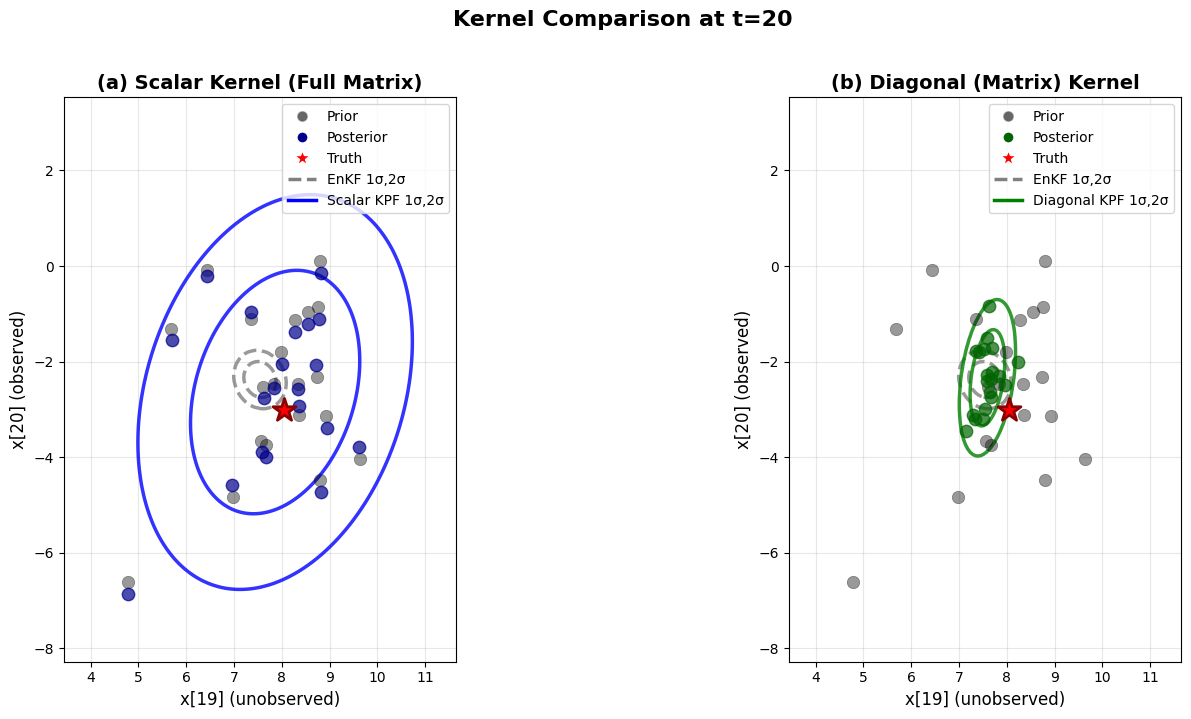


COMPARISON: Full-Matrix Scalar vs Diagonal Kernel
Blue (Scalar):  K(x,z) = k(||x-z||) · 1_{n×n} (FULL MATRIX, all entries equal)
Green (Diagonal): K(x,z) = diag[k_1(x_1,z_1), ..., k_n(x_n,z_n)]
Gray (EnKF):    Reference baseline


In [8]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Grid for contours
max_std_corr = max(np.sqrt(P_enkf_2d[0,0]), np.sqrt(P_scalar_corr_2d[0,0]), np.sqrt(P_diag_corr_2d[0,0]))
x_range_c = np.linspace(mean_enkf_2d[0] - 3.5*max_std_corr, mean_enkf_2d[0] + 3.5*max_std_corr, 150)
max_std_corr = max(np.sqrt(P_enkf_2d[1,1]), np.sqrt(P_scalar_corr_2d[1,1]), np.sqrt(P_diag_corr_2d[1,1]))
y_range_c = np.linspace(mean_enkf_2d[1] - 3.5*max_std_corr, mean_enkf_2d[1] + 3.5*max_std_corr, 150)
X_grid_c, Y_grid_c = np.meshgrid(x_range_c, y_range_c)
pos_c = np.dstack((X_grid_c, Y_grid_c))

chi2_levels = chi2.ppf([0.68, 0.95], df=2)

# (a) Scalar Kernel (Full Matrix)
ax = axes[0]

# EnKF
rv_enkf_c = multivariate_normal(mean_enkf_2d, P_enkf_2d)
Z_enkf_c = rv_enkf_c.pdf(pos_c)
max_d_enkf = rv_enkf_c.pdf(mean_enkf_2d)
ax.contour(X_grid_c, Y_grid_c, Z_enkf_c,
          levels=[max_d_enkf * np.exp(-c/2) for c in reversed(chi2_levels)],
          colors='gray', linewidths=2.5, alpha=0.8, linestyles='--')

# Scalar
rv_scalar_c = multivariate_normal(mean_scalar_corr_2d, P_scalar_corr_2d)
Z_scalar_c = rv_scalar_c.pdf(pos_c)
max_d_sc = rv_scalar_c.pdf(mean_scalar_corr_2d)
ax.contour(X_grid_c, Y_grid_c, Z_scalar_c,
          levels=[max_d_sc * np.exp(-c/2) for c in reversed(chi2_levels)],
          colors='blue', linewidths=2.5, alpha=0.8, linestyles='-')

ax.scatter(X_prior[:, var_unobserved], X_prior[:, var_observed], 
          c='black', s=80, alpha=0.4, edgecolors='black', linewidth=0.5, marker='o', zorder=3)
ax.scatter(X_post_scalar[:, var_unobserved], X_post_scalar[:, var_observed],
          c='darkblue', s=80, alpha=0.7, edgecolors='darkblue', linewidth=1, marker='o', zorder=4)
ax.scatter(truth_first[var_unobserved], truth_first[var_observed],
          c='red', s=300, marker='*', edgecolors='darkred', linewidth=2, zorder=5)

from matplotlib.lines import Line2D
leg_a = [
    Line2D([0], [0], marker='o', color='w', label='Prior', markerfacecolor='black', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Posterior', markerfacecolor='darkblue', markersize=8),
    Line2D([0], [0], marker='*', color='w', label='Truth', markerfacecolor='red', markersize=12),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=2.5, label='EnKF 1σ,2σ'),
    Line2D([0], [0], color='blue', linestyle='-', linewidth=2.5, label='Scalar KPF 1σ,2σ')
]
ax.legend(handles=leg_a, loc='upper right', fontsize=10)
ax.set_xlabel(var_labels[0], fontsize=12)
ax.set_ylabel(var_labels[1], fontsize=12)
ax.set_title('(a) Scalar Kernel (Full Matrix)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# (b) Diagonal Kernel
ax = axes[1]

ax.contour(X_grid_c, Y_grid_c, Z_enkf_c,
          levels=[max_d_enkf * np.exp(-c/2) for c in reversed(chi2_levels)],
          colors='gray', linewidths=2.5, alpha=0.8, linestyles='--')

rv_diag_c = multivariate_normal(mean_diag_corr_2d, P_diag_corr_2d)
Z_diag_c = rv_diag_c.pdf(pos_c)
max_d_diag = rv_diag_c.pdf(mean_diag_corr_2d)
ax.contour(X_grid_c, Y_grid_c, Z_diag_c,
          levels=[max_d_diag * np.exp(-c/2) for c in reversed(chi2_levels)],
          colors='green', linewidths=2.5, alpha=0.8, linestyles='-')

ax.scatter(X_prior[:, var_unobserved], X_prior[:, var_observed],
          c='black', s=80, alpha=0.4, edgecolors='black', linewidth=0.5, marker='o', zorder=3)
ax.scatter(X_post_diagonal[:, var_unobserved], X_post_diagonal[:, var_observed],
          c='darkgreen', s=80, alpha=0.7, edgecolors='darkgreen', linewidth=1, marker='o', zorder=4)
ax.scatter(truth_first[var_unobserved], truth_first[var_observed],
          c='red', s=300, marker='*', edgecolors='darkred', linewidth=2, zorder=5)

leg_b = [
    Line2D([0], [0], marker='o', color='w', label='Prior', markerfacecolor='black', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Posterior', markerfacecolor='darkgreen', markersize=8),
    Line2D([0], [0], marker='*', color='w', label='Truth', markerfacecolor='red', markersize=12),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=2.5, label='EnKF 1σ,2σ'),
    Line2D([0], [0], color='green', linestyle='-', linewidth=2.5, label='Diagonal KPF 1σ,2σ')
]
ax.legend(handles=leg_b, loc='upper right', fontsize=10)
ax.set_xlabel(var_labels[0], fontsize=12)
ax.set_ylabel(var_labels[1], fontsize=12)
ax.set_title('(b) Diagonal (Matrix) Kernel', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.suptitle(f'Kernel Comparison at t={t_first}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("COMPARISON: Full-Matrix Scalar vs Diagonal Kernel")
print("="*80)
print(f"Blue (Scalar):  K(x,z) = k(||x-z||) · 1_{{n×n}} (FULL MATRIX, all entries equal)")
print(f"Green (Diagonal): K(x,z) = diag[k_1(x_1,z_1), ..., k_n(x_n,z_n)]")
print(f"Gray (EnKF):    Reference baseline")
print("="*80)


To better demonstrate that **matrix-valued kernels prevent collapse** in high-dimensional systems, we should examine:

1. **Variance reduction in OBSERVED dimensions**: How much does each filter reduce uncertainty in observed variables?
2. **Variance reduction in UNOBSERVED dimensions**: Does the filter appropriately propagate information to unobserved variables?
3. **Balance between observed and unobserved**: A good filter should reduce uncertainty in both, avoiding over-concentration in observed dimensions at the expense of unobserved ones.

Hence we analyze the full-dimensional posterior covariances:

In [9]:
# Analyze variance reduction for observed vs unobserved dimensions
import matplotlib.pyplot as plt

# Compute prior variances
prior_var = np.var(X_prior, axis=0)

# Compute posterior variances for each method
enkf_var = np.var(X_enkf, axis=0)
scalar_var = np.var(X_post_scalar, axis=0)
diag_var = np.var(X_post_diagonal, axis=0)

# Separate observed and unobserved dimensions
H_idx = result.H_idx
unobserved_idx = np.setdiff1d(np.arange(result.config['nx']), H_idx)

# Compute mean variances for observed/unobserved
print("="*80)
print("VARIANCE ANALYSIS: Observed vs Unobserved Dimensions")
print("="*80)

print(f"\nNumber of observed dimensions: {len(H_idx)}")
print(f"Number of unobserved dimensions: {len(unobserved_idx)}")

print(f"\n{'Method':<25} {'Observed Var':<15} {'Unobserved Var':<15} {'Ratio (Obs/Unobs)'}")
print("-"*80)

# Prior
obs_prior = prior_var[H_idx].mean()
unobs_prior = prior_var[unobserved_idx].mean()
print(f"{'Prior':<25} {obs_prior:<15.6f} {unobs_prior:<15.6f} {obs_prior/unobs_prior:<.4f}")

# EnKF
obs_enkf = enkf_var[H_idx].mean()
unobs_enkf = enkf_var[unobserved_idx].mean()
print(f"{'EnKF':<25} {obs_enkf:<15.6f} {unobs_enkf:<15.6f} {obs_enkf/unobs_enkf:<.4f}")

# Scalar Kernel
obs_scalar = scalar_var[H_idx].mean()
unobs_scalar = scalar_var[unobserved_idx].mean()
print(f"{'Scalar Kernel':<25} {obs_scalar:<15.6f} {unobs_scalar:<15.6f} {obs_scalar/unobs_scalar:<.4f}")

# Diagonal Kernel
obs_diag = diag_var[H_idx].mean()
unobs_diag = diag_var[unobserved_idx].mean()
print(f"{'Diagonal Kernel':<25} {obs_diag:<15.6f} {unobs_diag:<15.6f} {obs_diag/unobs_diag:<.4f}")

print("\n" + "="*80)
print("VARIANCE REDUCTION (% reduction from prior)")
print("="*80)

print(f"\n{'Method':<25} {'Observed':<15} {'Unobserved':<15}")
print("-"*80)

enkf_obs_red = 100 * (1 - obs_enkf/obs_prior)
enkf_unobs_red = 100 * (1 - unobs_enkf/unobs_prior)
print(f"{'EnKF':<25} {enkf_obs_red:<15.2f}% {enkf_unobs_red:<15.2f}%")

scalar_obs_red = 100 * (1 - obs_scalar/obs_prior)
scalar_unobs_red = 100 * (1 - unobs_scalar/unobs_prior)
print(f"{'Scalar Kernel':<25} {scalar_obs_red:<15.2f}% {scalar_unobs_red:<15.2f}%")

diag_obs_red = 100 * (1 - obs_diag/obs_prior)
diag_unobs_red = 100 * (1 - unobs_diag/unobs_prior)
print(f"{'Diagonal Kernel':<25} {diag_obs_red:<15.2f}% {diag_unobs_red:<15.2f}%")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
if scalar_obs_red < 5 and scalar_unobs_red < 5:
    print("❌ Scalar Kernel: FAILS to reduce uncertainty in both observed and unobserved dimensions")
elif scalar_obs_red > 50 and scalar_unobs_red < 10:
    print("⚠️  Scalar Kernel: COLLAPSES observed dimensions but fails to update unobserved dimensions")
else:
    print("✓ Scalar Kernel: Shows some variance reduction")

if diag_obs_red > 50 and diag_unobs_red > 20:
    print("✅ Diagonal Kernel: Successfully reduces uncertainty in BOTH observed and unobserved dimensions")
    print("   → This demonstrates the advantage of adaptive per-dimension lengthscales")
else:
    print("⚠️  Diagonal Kernel: Shows imbalanced variance reduction")

print("="*80)

VARIANCE ANALYSIS: Observed vs Unobserved Dimensions

Number of observed dimensions: 250
Number of unobserved dimensions: 750

Method                    Observed Var    Unobserved Var  Ratio (Obs/Unobs)
--------------------------------------------------------------------------------
Prior                     3.055581        3.047874        1.0025
EnKF                      0.070759        0.075371        0.9388
Scalar Kernel             3.019684        3.026166        0.9979
Diagonal Kernel           0.337361        0.334357        1.0090

VARIANCE REDUCTION (% reduction from prior)

Method                    Observed        Unobserved     
--------------------------------------------------------------------------------
EnKF                      97.68          % 97.53          %
Scalar Kernel             1.17           % 0.71           %
Diagonal Kernel           88.96          % 89.03          %

KEY FINDINGS:
❌ Scalar Kernel: FAILS to reduce uncertainty in both observed and unobserved

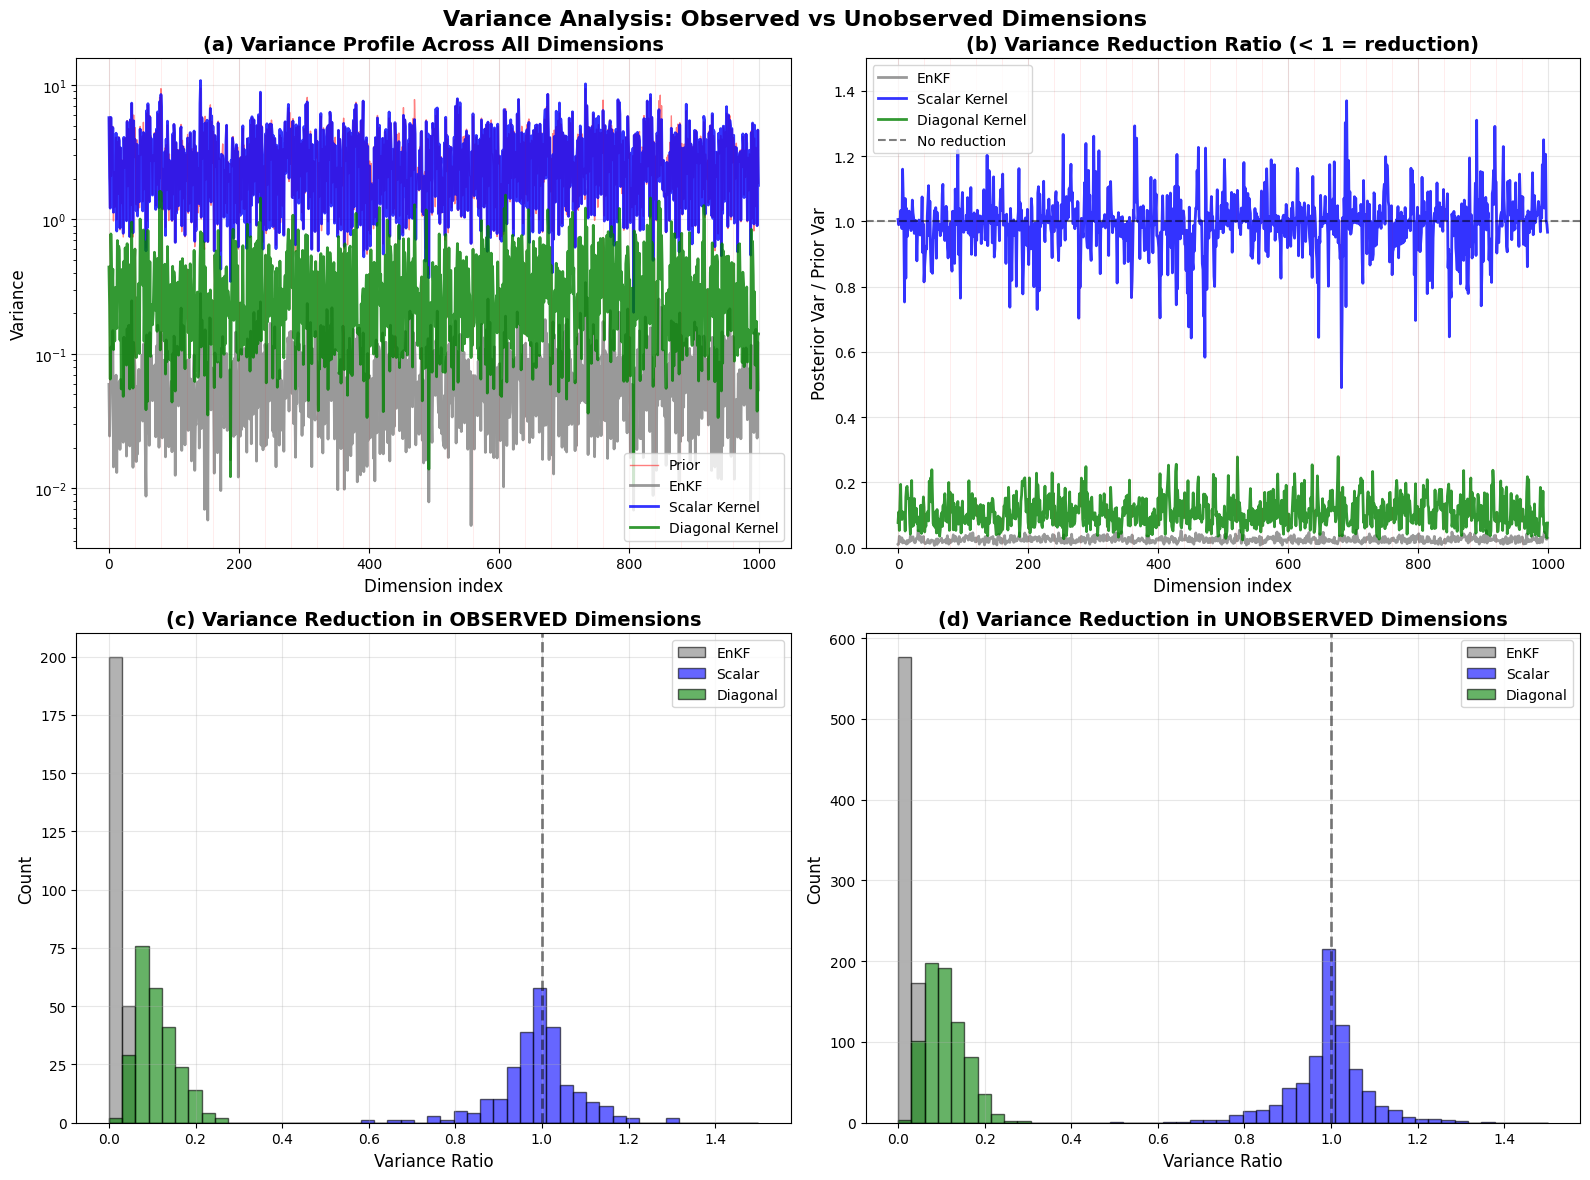


📊 Interpretation:
- Panel (c): Observed dimensions should show strong variance reduction (ratio << 1)
- Panel (d): Unobserved dimensions benefit from spatial correlations
- A good filter balances reduction in both observed and unobserved dimensions


In [14]:
# Visualize variance profiles across all dimensions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Variance profiles
ax = axes[0, 0]
ax.plot(prior_var, 'r-', alpha=0.5, linewidth=1, label='Prior')
ax.plot(enkf_var, 'gray', alpha=0.8, linewidth=2, label='EnKF')
ax.plot(scalar_var, 'b-', alpha=0.8, linewidth=2, label='Scalar Kernel')
ax.plot(diag_var, 'g-', alpha=0.8, linewidth=2, label='Diagonal Kernel')

# Mark observed dimensions
for h in H_idx[::10]:  # Mark every 10th observed variable to avoid clutter
    ax.axvline(h, color='red', alpha=0.1, linewidth=0.5)
    
ax.set_xlabel('Dimension index', fontsize=12)
ax.set_ylabel('Variance', fontsize=12)
ax.set_title('(a) Variance Profile Across All Dimensions', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# (b) Variance reduction ratio
ax = axes[0, 1]
variance_ratio_enkf = enkf_var / prior_var
variance_ratio_scalar = scalar_var / prior_var
variance_ratio_diag = diag_var / prior_var

ax.plot(variance_ratio_enkf, 'gray', alpha=0.8, linewidth=2, label='EnKF')
ax.plot(variance_ratio_scalar, 'b-', alpha=0.8, linewidth=2, label='Scalar Kernel')
ax.plot(variance_ratio_diag, 'g-', alpha=0.8, linewidth=2, label='Diagonal Kernel')
ax.axhline(1.0, color='k', linestyle='--', alpha=0.5, label='No reduction')

for h in H_idx[::10]:
    ax.axvline(h, color='red', alpha=0.1, linewidth=0.5)

ax.set_xlabel('Dimension index', fontsize=12)
ax.set_ylabel('Posterior Var / Prior Var', fontsize=12)
ax.set_title('(b) Variance Reduction Ratio (< 1 = reduction)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.5])

# (c) Observed dimensions histogram
ax = axes[1, 0]
bins = np.linspace(0, 1.5, 50)
ax.hist(variance_ratio_enkf[H_idx], bins=bins, alpha=0.6, color='gray', label='EnKF', edgecolor='black')
ax.hist(variance_ratio_scalar[H_idx], bins=bins, alpha=0.6, color='blue', label='Scalar', edgecolor='black')
ax.hist(variance_ratio_diag[H_idx], bins=bins, alpha=0.6, color='green', label='Diagonal', edgecolor='black')
ax.axvline(1.0, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel('Variance Ratio', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('(c) Variance Reduction in OBSERVED Dimensions', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# (d) Unobserved dimensions histogram
ax = axes[1, 1]
ax.hist(variance_ratio_enkf[unobserved_idx], bins=bins, alpha=0.6, color='gray', label='EnKF', edgecolor='black')
ax.hist(variance_ratio_scalar[unobserved_idx], bins=bins, alpha=0.6, color='blue', label='Scalar', edgecolor='black')
ax.hist(variance_ratio_diag[unobserved_idx], bins=bins, alpha=0.6, color='green', label='Diagonal', edgecolor='black')
ax.axvline(1.0, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel('Variance Ratio', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('(d) Variance Reduction in UNOBSERVED Dimensions', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Variance Analysis: Observed vs Unobserved Dimensions', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- Panel (c): Observed dimensions should show strong variance reduction (ratio << 1)")
print("- Panel (d): Unobserved dimensions benefit from spatial correlations")
print("- A good filter balances reduction in both observed and unobserved dimensions")